# LOCO CV to Optimize Ridge Regression Model
Determine whether LOCO CV can improve performance

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold, BaseCrossValidator, cross_val_predict, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import pearsonr
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import numpy as np
import os

Set the seed for reproducibility

In [2]:
np.random.seed(1)

## Load in the Data
Readin data from the Supplementary Materials of [Agrawal *et al* 2014](https://link.springer.com/article/10.1186%2F2193-9772-3-8#MOESM1)

In [3]:
data = pd.read_excel(os.path.join('datasets', 'Steel-Dataset.xlsx'))

Get the list of input and output columns

In [4]:
X_cols = data.columns[1:-1]
print('{} input variables:'.format(len(X_cols)), X_cols)

25 input variables: Index(['NT', 'THT', 'THt', 'THQCr', 'CT', 'Ct', 'DT', 'Dt', 'QmT', 'TT', 'Tt',
       'TCr', 'C', 'Si', 'Mn', 'P', 'S', 'Ni', 'Cr', 'Cu', 'Mo', 'RedRatio',
       'dA', 'dB', 'dC'],
      dtype='object')


In [5]:
y_col = data.columns[-1]
print('Output column:', y_col)

Output column: Fatigue


## Create the LOCO CV Splitter
Create a class that uses scikit-learn's BaseCrossValidator API, so that it can be used to easily perform cross-validation etc.

In [6]:
class LocoCV(BaseCrossValidator):
    """Generates train/test splits for Leave-One-Cluster-Out cross-validation
    
    Follows the API for scikit-learns cross-validation classes
    
    Parameters
    ----------
    clusterer : ClustererMixin, tool used to generate clusters"""
    
    def __init__(self, clusterer=KMeans()):
        self.clusterer = clusterer
        
    def _iter_test_masks(self, X, y=None, groups=None):
                # Train the clusterer and generate cluster labels
        labels = self.clusterer.fit_predict(X)
        
        # Determine the number of clusters
        clust_labels = np.unique(labels)
        if len(clust_labels) < 2:
            raise ValueError('Clusterer produced < 2 labels. Cannot use for LOCO CV')
            
        # Loop thorugh the clusters
        for label in clust_labels:
            yield labels == label
    
    def get_n_splits(self, X, y=None, groups=None):
        return len(np.unique(self.clusterer.fit_predict(X)))

## Define the KMeans Clusterer
This clusterer will be used for both testing and training

In [7]:
kmeans = Pipeline([
    ('normalize', StandardScaler()),
    ('kmeans', KMeans(n_clusters=10, random_state=1))
])

## Create Ridge Models
Use the entire training set to determine appropriate ridge parameters.

LW 24Feb18: I'd prefer to not use the entire dataset to fit parameters to the model. Idealyl, I'd prefer to re-run grid search during each iteration of LOCO CV. But, given the few numbers of clusters in this dataset (3!), this means the training set will be remarkably different for each of iterations.

In [8]:
alpha_range = np.logspace(-4, 4, 32)

In [15]:
kfold_ridge = GridSearchCV(Ridge(), dict(alpha=alpha_range), scoring='explained_variance', cv=KFold(n_splits=10, shuffle=True))\
    .fit(data[X_cols], data[y_col]).best_estimator_
kfold_ridge

Ridge(alpha=0.0035349811050301057, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Use LOCO CV to set the regularization parameter. `GridSearchCV` averages the score across all test folds, which Bryce has noticed is problematic. 

In [16]:
scores = []
for alpha in tqdm(alpha_range):
    model = Ridge(alpha=alpha)
    my_scores = []
    for i in range(20):
        kmeans.set_params(kmeans__random_state=i)
        pred_y = cross_val_predict(model, data[X_cols], data[y_col], cv=LocoCV(kmeans))
        my_scores.append(pearsonr(pred_y, data[y_col])[0])
    scores.append(np.mean(my_scores))
loco_ridge = Ridge(alpha=alpha_range[np.argmax(scores)])
loco_ridge

HBox(children=(IntProgress(value=0, max=32), HTML(value='')))

Ridge(alpha=0.021017480113324872, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

## Test them on the Steel Dataset 
Test each model using both LOCO CV and conventional 10-fold CV to set the ridge regression parameter. We are going to test the performance of the model over 10 iterations of a 10-fold CV and LOCO CV test with k=10.

In [11]:
kfold_R = []
loco_R = []
for i in tqdm(range(10)):
    # Test the regular model
    pred_y = cross_val_predict(kfold_ridge, data[X_cols], data[y_col], cv=KFold(n_splits=10, shuffle=True, random_state=i))
    kfold_R.append(pearsonr(data[y_col], pred_y)[0])

    # Test the LOCO model
    pred_y = cross_val_predict(loco_ridge, data[X_cols], data[y_col], cv=KFold(n_splits=10, shuffle=True, random_state=i))
    loco_R.append(pearsonr(data[y_col], pred_y)[0])
print('Optimization with K-fold CV: Median={:.2f} Std={:.2f} over {} tests'.format(
    np.median(kfold_R), np.std(kfold_R), len(kfold_R)))
print('LOCO CV: Median={:.2f} Std={:.2f} over {} tests'.format(np.median(loco_R), np.std(loco_R), len(loco_R)))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))


Optimization with K-fold CV: Median=0.98 Std=0.00 over 10 tests
LOCO CV: Median=0.98 Std=0.00 over 10 tests


*Finding*: The LOCO  conventional CV models achieve identical performance on this test

Repeat test using LOCO CV to test model performance

In [12]:
kfold_R = []
loco_R = []
for i in tqdm(range(50)):
    # Set the random seed of the clusterer
    kmeans.steps[-1][1].random_state = i
    lococv = LocoCV(kmeans)
    
    # Test the regular model
    pred_y = cross_val_predict(kfold_ridge, data[X_cols], data[y_col], cv=lococv)
    kfold_R.append(pearsonr(data[y_col], pred_y)[0])

    # Test the LOCO model
    pred_y = cross_val_predict(loco_ridge, data[X_cols], data[y_col], cv=lococv)
    loco_R.append(pearsonr(data[y_col], pred_y)[0])

print('Optimization with K-fold CV: Median={:.2f} Std={:.2f} over {} tests'.format(
    np.median(kfold_R), np.std(kfold_R), len(kfold_R)))
print('LOCO CV: Median={:.2f} Std={:.2f} over {} tests'.format(np.median(loco_R), np.std(loco_R), len(loco_R)))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))


Optimization with K-fold CV: Median=-0.44 Std=0.66 over 50 tests
LOCO CV: Median=-0.38 Std=0.63 over 50 tests


*Finding*: The performance of both models on the LOCO CV test are worse, and the test that uses LOCO CV to set the parameters  does slightly better than the original model.

Text(0,0.5,'Count')

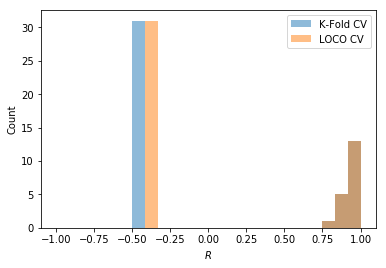

In [13]:
fig, ax = plt.subplots()

bins=np.linspace(-1, 1, 25)
ax.hist(kfold_R, bins=bins, alpha=0.5, label='K-Fold CV')
ax.hist(loco_R, bins=bins, alpha=0.5, label='LOCO CV')

ax.legend()

ax.set_xlabel('$R$')
ax.set_ylabel('Count')

*Finding*: There is some kind of wierd, bi-model behavior. Does the better performance occur when Kmeans places 9/10 centroids in the 2 of the 3 clusters?